<a href="https://colab.research.google.com/github/gyuwhi-park/Study/blob/Python/Playing_poker(Texas_hold'em).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#텍사스 홀덤
1. 목적 : 파이썬 문법 및 자료구조의 활용하여 프로그램 한가지 만들어 보기

2. 기능
    - 포커게임에서 핸드를 알려주고 점수를 계산하여 승자를 판별
    - 플레이어별 핸드를 보여주고, 핸드 중 족보에 해당하는 패만 선별하여 새로 출력
    - 핸드와 족보에 해당하는 카드를 이미지로 출력
    - 이미지의 호출은 패턴+숫자를 파일명으로 불러온다.
    - 각 플레이어별로 출력시 패턴이나 숫자 등 의미있는 정보를 같이 출력한다.

3. 점수 : 동점을 만들지 않기위해 우선순위에 따라 비중을 달리하여 점수화한다.
    - 높은 족보일수록 높은 번호 부여, 해당 번호 * 100을 점수로 한다.
    - 족보에 해당하는 숫자 중 가장 큰 숫자를 점수에 더한다.
    - 해당 카드의 패턴을 순위에 따라 1~4로 하고, 0.1을 곱해서 점수에 더한다.

4. 자료구조 활용한 부분
    - 리스트 : 가장 많이 사용함. 패턴, 숫자 카운트 하는 기능은 잦은 수정이 일어나기때문.
    - 딕셔너리 : 패턴에 대한 값을 받을때 사용함.
    - 원형 큐 : 스트레이트에서 K에서 에이스로 넘어갈때 연속된 것으로 사용하기 위해 사용
    - 스택 : 카드 덱을 구성한 후 제거하기만 있는데, 뒤쪽을 상단으로 하여 제거한다
    - linked 리스트 : 각 플레이어는 각각 다른 객체 이기때문에 최종점수를 확인하기 위해서 외부 객체에 접근하여 내부의 값을 읽어오기 위해 linked 리스트에서 배운 방법을 사용함. (이때 각 플레이어에 접근하기 위해 플레이어의 수 만큼 array 리스트를 만들어 각 인덱스에 연결시켰음)


##게임 규칙
1. 드로우
- 하우스는 총 5장을 드로우한다.
- 각 플레이어는 2장씩을 드로우한다.
2. 동점자 규정
- 점수는 족보가 좋은사람이 승리한다.
- 족보가 같으면 더 숫자가 큰 카드를 가진 플레이어가 승리한다. K 보다 A를 더 큰 숫자로 한다.
- 숫자도 같은 경우 패턴으로 승리를 결정한다.
- 패턴과 상관없이 숫자가 5개 이어진 조합을 만드는 경우 스트레이트로 인정한다. 이때 K에서 A로 넘어가는 것도 연속된 것으로 인정하며, 특정 숫자들로 조합되는 경우 Back Straight / Mountain 등으로 부르며 지정된 점수를 받는다.
- 같은 패턴의 카드 5장을 조합하는 경우 플러시라고 한다. 플러시에서 스트레이트를 조합할 수 있는 경우 스트레이트플러시라고 하며 지정된 점수를 받는다.
- 족보의 점수는 해당 조합을 만들수 있는 확률을 기반하여 확률이 낮을수록 높은 가치를 부여받는다.
- 족보는 아래와 같다.

###족보
    spade > diamond > heart > clover

    Royal straight flush : same pattern + 10,j,q,k,a                #12

    back stragith flush : same pattern + 1,2,3,4,5                  #11

    straight flush : same pattern + connected number                #10
    
    4 card : 4 same numbered cards                                  #9

    full house :  triple + one pair  /   {} top full house          #8

    flush : 5 same pattern cards    /   {}pattern flush             #7

    mountain : 10, j, q, k, a   /   pattern                         #6

    back striaght : a, 2,3,4,5  /   pattern                         #5

    straight : connected 5 cards    /   {}top , {}pattern straight  #4

    triple : 3 same number cards    /   {} triple                   #3

    two pair : 2 same number cards *2 /   {}, {} two pairs          #2

    one pair : 2 same number cards  /   {}pair                      #1

In [ ]:
import random
import numpy as np
import cv2

from google.colab import files
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#플레이어 함수

In [ ]:
class act_player():
    def __init__(self, house_deck, player_deck):
        self.hand = player_deck      #hand - 7장 가지는 것
        self.hand.extend(house_deck)
        self.pc=[0,0,0,0]   #pattern counter, 패턴은 S,D,H,C 순서
        self.nc=[0,0,0,0,0, #number counter, 0~12의 범위에서 숫자 생성.
                 0,0,0,0,0,
                 0,0,0]
        self.name = ['A', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
        self.p_name = ["Spade", "Diamond", "Heart", "Clover"]

        self.pattern = {'S' : 0, 'D' : 1, 'H' : 2, 'C' : 3}
        self.f_hand = []
        self.n_hand = []    #new hand - 5~7장 가지는 것-> in case of flush
        self.f_nc=[0,0,0,0,0, #flush number counter
                   0,0,0,0,0,
                   0,0,0]

        self.top=0
        self.one_pair=100 ;   self.two_pair=200     ;   self.triple=300
        self.straight=400 ;   self.b_straight=500   ;   self.mountain=600
        self.flush=700    ;   self.full_house=800   ;   self.four_card=900
        self.s_flush=1000 ;   self.bs_flush=1100    ;   self.RSF=1200
        self.count()

        #printing part
        self.rank = self.hand_rank() # -> try to return to main function to decide winner
        #print(f"rank = {self.rank}")
        print("Hand")
        cv2_imshow(self.hconcat_img(self.hand))
        print("Combination")
        self.n_hand.sort()
        self.cal_rank()
        cv2_imshow(self.hconcat_img(self.n_hand))
        print()

    def cal_rank(self):
        #가장 높은 카드 계산
        self.rank += self.n_hand[-1][0]
        #패턴 점수        
        self.rank += 0.5 - self.pattern[self.n_hand[-1][1]]

    def count(self):
        for i in range(7):
            p=self.hand[i][1]  #numbers
            n=self.hand[i][0]  #pattern
            self.pc[self.pattern[p]] += 1
            self.nc[n]+=1
        #print(self.pc)
        #print(self.nc)

    def hand_rank(self):
        #flush check
        num_pattern = max(self.pc)
        num = max(self.nc)
        #if flush
        if num_pattern > 4:
            pattern = self.pc.index(num_pattern)
            for i in range(7):
                if self.hand[i][1] == self.p_name[pattern][0]:
                    self.f_hand.append(self.hand[i])
                    self.f_nc[self.hand[i][0]] += 1

            if self.straight_check(self.f_nc) is True:
                if self.nc[9] > 0 and self.nc[0] > 0:
                    print("{} Royal Straight Flush".format(self.p_name[pattern]))
                    return self.RSF
                elif self.nc[0] > 0 and self.nc[4] > 0:
                    print("{} Back Straight Flush".format(self.p_name[pattern]))
                    return self.bs_flush
                else:
                    print("{} Straight Flush".format(self.p_name[pattern]))
                    return self.s_flush
            
            else:
                #four cards
                if num == 4:
                    print(f"{self.name[self.nc.index(num)]} Four cards")
                    for i in range(7):
                        if self.hand[i][0] == self.nc.index(4):
                            self.n_hand.append(self.hand[i])
                    return self.four_card #, self.nc.index(num)
                
                elif 2 and 3 in self.nc:
                    #tiple
                    val1 = 0
                    for i in range(7):
                        if self.hand[i][0] == (len(self.nc)-1-self.nc[::-1].index(3)):
                            self.n_hand.append(self.hand[i])
                            val1 = self.hand[i][0]  #full house에서 사용
                    #pairs
                    pair = []
                    for i in range(13):
                        if self.nc[i] == 2:
                            pair.append(i)
                    
                    val2 = max(pair)
                    for i in range(7):
                        if self.hand[i][0] == val2:
                            self.n_hand.append(self.hand[i])
                            #val2 = self.hand[i][0] + 1  #full house에서 사용
                    print("{},{}  Full house".format(self.name[val1 + 1], self.name[val2 + 1]))
                    return self.full_house

                #case of flush
                else:
                    self.n_hand = self.f_hand
                    #self.n_hand.sort()
                    print("{} Flush".format(self.p_name[pattern]))
                    return self.flush

        #if not flush
        else:
            #four cards
            if num == 4:
                print(f"{self.name[self.nc.index(num)]} Four cards")
                for i in range(7):
                    if self.hand[i][0] == self.nc.index(4):
                        self.n_hand.append(self.hand[i])
                return self.four_card #, self.nc.index(num)
            #triple
            elif num == 3:
                val1 = 0
                for i in range(7):
                    if self.hand[i][0] == (len(self.nc)-1-self.nc[::-1].index(3)):
                        self.n_hand.append(self.hand[i])
                        val1 = self.hand[i][0] + 1
                else:
                    print(f"{self.name[val1-1]} Tiple")
                    return self.triple
            
            elif self.straight_check(self.nc) is True:
                if self.nc[9] > 0 and self.nc[0] > 0:
                    print("Mountain")
                    return self.mountain
                elif self.nc[0] > 0 and self.nc[4] > 0:
                    print("Back straight")
                    return self.b_straight
                else:
                    print("Straight")
                    return self.straight

            #pairs
            elif num == 2:
                pair = []
                for i in range(13):
                    if self.nc[i] == 2:
                        pair.append(i)
                if len(pair) == 3:
                    pair.pop(min(pair))     #in case of 3 pair
                for i in range(7):
                    if self.hand[i][0] in pair:
                        self.n_hand.append(self.hand[i])
                #print(f"pair : {pair}")
                if len(pair) > 1:
                    print(f"{self.name[pair[-1]]}, {self.name[pair[-2]]} two pair")
                    return self.two_pair
                else:
                    print(f"{self.name[pair[0]]} one pair")
                    return self.one_pair

            #top
            else:
                #ace top
                if self.nc[0] == 1:
                    for i in range(7):
                        if self.hand[i][0] == 0:
                            self.n_hand.append(self.hand[i])
                            break
                    print(f"{self.p_name[self.pattern[self.n_hand[0][1]]]} Ace TOP")
                    return self.top

                else:
                    max_card = self.hand[0]
                    for i in range(1, 7):
                        if self.hand[i][0] > max_card[0]:
                            max_card = self.hand[i]
                    self.n_hand.append(max_card)
                    print("{} {} TOP".format(self.p_name[self.pattern[self.n_hand[0][1]]], self.name[self.n_hand[0][0]]))
                    return self.top

    def straight_check(self, card_list):
        counter = 0
        start = 0
        for i in range(18):
            if card_list[i % 13] != 0:
                counter += 1
                start = i + 1 - counter
                #print(f"i = {i}, val = {card_list[i]}, counter = {counter}, start = {i + 1 - counter}")
            else:
                if counter > 4:
                    if start == 0 or start == 9:
                        st_list = [x % 13 for x in range(i-1 - (counter-5),i -1 - counter,-1)]
                    else:
                        st_list = [x % 13 for x in range(i-1,i -1 - 5,-1)]
                    #print(st_list)
                    for i in range(7):
                        if self.hand[i][0] in st_list:
                            self.n_hand.append(self.hand[i])
                            st_list.remove(self.hand[i][0])
                    #print(self.n_hand)
                    #self.n_hand.sort()
                    return True
                counter = 0
        return False

        #list of card images
        # <class 'numpy.ndarray'>인 경우만 사용 가능.
    def hconcat_img(self, img_list, interpolation = cv2.INTER_CUBIC):
        #convert
        card_img = []
        for i in range(len(img_list)):
            chr = img_list[i][1]
            num = img_list[i][0] + 1
            #control images
            card_img.append((cv2.imread(f"/content/gdrive/MyDrive/52 trump cards/{chr}{num}.jpg")))

        #usage
        w_min = min(img.shape[0] for img in card_img)
        img_list_resize = [cv2.resize(im, (int(im.shape[1] * w_min / im.shape[0]), w_min), interpolation = interpolation) for im in card_img]
        return cv2.hconcat(img_list_resize)

    def getter(self):
        print("self.hand : {}".format(self.hand))
        cv2_imshow(self.hconcat_img(self.hand))
        print(f"self.pc : {self.pc}")   #pattern counter, 패턴은 S,D,H,C 순서
        print(f"self.nc : {self.nc}")
        print(f"self.n_hand : {self.n_hand}")
        cv2_imshow(self.hconcat_img(self.n_hand))
        print(f"self.n_nc : {self.f_nc}")

In [ ]:
#p1 = act_player([[12, 'S'], [0, 'S'], [9, 'S'], [10, 'S'], [11, 'S']], [[2, 'D'], [11, 'C']])
#print(p1.rank)

In [ ]:
#p1.getter()

#포커 프로그램

In [ ]:
#New deck
class Texas_holdem():
    def __init__(self):
        self.d=[]    ;   self.h=[]    ;   self.c=[]    ;   self.s=[]    #pattern별 카드
        self.house_deck=[]   ;   self.deck=[]   ;   self.player=[]  ;   self.num=0  ;   self.hor=[] #hand of rank  
        self.setting()
        self.shuffle()
        self.draw_p()   ;   self.draw_h()

    #포인트가 높은 것이 우선순위를 가진다. RSF는 12점으로, 다른어떤 것보다 점수가 높다.
    #페어조차 없는 top의 경우 숫자가 크거나, 숫자가 같은 경우 문양의 우세함으로 판단한다.

    #플레이어 수 설정
    def setting(self):
        self.num=int(input("플레이어의 수를 입력해 주십시오 >> "))   #player number
        for i in range(self.num):
            self.player.append([])
            self.hor.append([])     #hor : hand of rank
        print("등록된 플레이어는 {}명 입니다.".format(self.num))
        print()

    #카드 덱 생성, 셔플
    def shuffle(self):
        self.deck=[]
        self.d=[]    ;   self.h=[]    ;   self.c=[]    ;   self.s=[]
        for i in range(13):     #숫자생성 0~12
            self.d.append([i, "D"])
            self.s.append([i, "S"])
            self.c.append([i, "C"])
            self.h.append([i, "H"])
        self.deck.extend(self.d) ;   self.deck.extend(self.h)
        self.deck.extend(self.c) ;   self.deck.extend(self.s)
        random.shuffle(self.deck)

    #카드 덱에서 드로우(맨 위)
    def draw(self):
        N_card=self.deck.pop()
        #print(N_card)
        return N_card

    #draw player - 2장씩
    def draw_p(self):
        for i in range(self.num):
            for j in range(2):
                card=self.draw()
                self.player[i].append(card)
        #for i in range(self.num):
            #print(self.player[i])

    #draw house
    def draw_h(self):
        for i in range(5):
            self.house_deck.append(self.draw())
        #print(self.house_deck)

    def getter(self):
        print(f"self.house_deck : {self.house_deck}")
        for i in range(self.num):
            print(f"Player{i+1} : {self.player[i]}")

    def count_player(self):
        for i in range(self.num):
            #print(f"player {i+1} : {self.house_deck + self.player[i]}")
            print(f"player {i+1}")
            result = act_player(self.house_deck, self.player[i])
            self.hor[i] = result.rank
            print()
        print(self.hor)
        print(f"Winner is player{i}")


플레이어의 수를 입력해 주십시오 >> 5
등록된 플레이어는 5명 입니다.

player 1
8 one pair
Hand


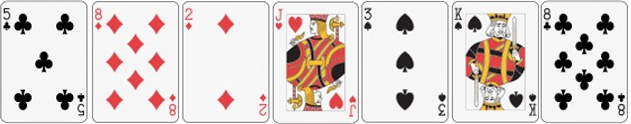

Combination


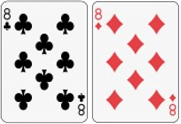



player 2
2 one pair
Hand


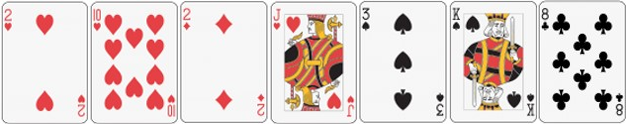

Combination


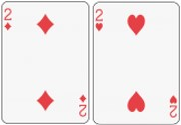



player 3
Spade Ace TOP
Hand


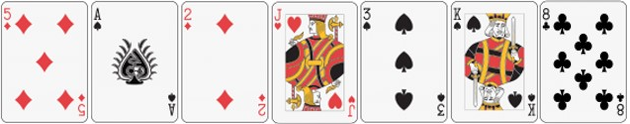

Combination


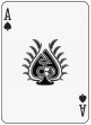



player 4
K one pair
Hand


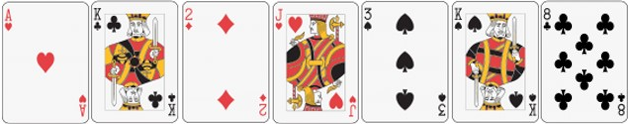

Combination


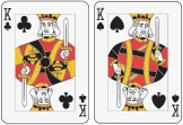



player 5
Spade K TOP
Hand


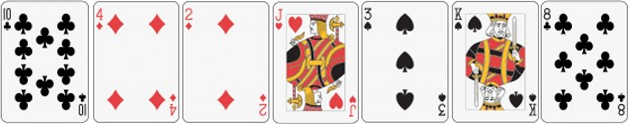

Combination


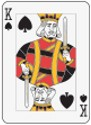



[106.5, 99.5, 0.5, 112.5, 12.5]
Winner is player4


In [ ]:
a = Texas_holdem()
a.count_player()

In [ ]:
a.getter()

self.house_deck : [[1, 'D'], [10, 'H'], [2, 'S'], [12, 'S'], [7, 'C']]
Player1 : [[4, 'C'], [7, 'D'], [1, 'D'], [10, 'H'], [2, 'S'], [12, 'S'], [7, 'C']]
Player2 : [[1, 'H'], [9, 'H'], [1, 'D'], [10, 'H'], [2, 'S'], [12, 'S'], [7, 'C']]
Player3 : [[4, 'D'], [0, 'S'], [1, 'D'], [10, 'H'], [2, 'S'], [12, 'S'], [7, 'C']]
Player4 : [[0, 'H'], [12, 'C'], [1, 'D'], [10, 'H'], [2, 'S'], [12, 'S'], [7, 'C']]
Player5 : [[9, 'C'], [3, 'D'], [1, 'D'], [10, 'H'], [2, 'S'], [12, 'S'], [7, 'C']]
